In [1]:
cd ~/ESRGAN/

/Users/felixmeng/ESRGAN


In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os 
import os.path as osp
import glob
import cv2
import numpy as np
import torch
import RRDBNet_arch as arch
from PIL import Image
import albumentations as A

In [3]:
#The Brown distortion model 

In [4]:
# The radial distortion coefficients model this type of distortion. The distorted points are denoted as (xdistorted, ydistorted):
# xdistorted = x(1 + k1*r2 + k2*r4 + k3*r6)
# ydistorted= y(1 + k1*r2 + k2*r4 + k3*r6)
# x, y — Undistorted pixel locations. x and y are in normalized image coordinates. Normalized image coordinates are calculated from pixel coordinates by translating to 
#the optical center and dividing by the focal length in pixels. Thus, x and y are dimensionless.
# k1, k2, and k3 — Radial distortion coefficients of the lens.
# r2 = x2 + y2

In [5]:
## architecture of ECGr GAn

In [6]:
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk

        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))

        return out


## Executing the program

In [5]:

model_path = 'models/RRDB_ESRGAN_x4.pth' 
device = torch.device('cpu')  

test_img_folder = 'LR/*'

model = arch.RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

print('Model path {:s}. \nTesting...'.format(model_path))

idx = 0
for path in glob.glob(test_img_folder):
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)
    # read images
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(device)

    with torch.no_grad():
        output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()
    cv2.imwrite('results/{:s}_rlt.png'.format(base), output)
print("Transformation complete")

Model path models/RRDB_ESRGAN_x4.pth. 
Testing...
1 original_image1
Transformation complete


In [6]:
def radial_distortion(img,distortion_k):
    x_dim = img.shape[0]
    y_dim = img.shape[1]
    img_distorted = np.zeros(img.shape).astype(np.uint8)
    
    ## assumed the center to be the optical center, can be changed later
    x_optic= x_dim//2
    y_optic= y_dim//2
    x_focal=x_dim//2
    y_focal= y_dim//2
    k1,k2,k3= distortion_k
    r_max = np.sqrt(2) ## since x_norm <=1 and y_norm <=1
    scale = 1+ k1*(r_max**2) + k2*(r_max**4) + k3*(r_max**6)
    for x in range (x_dim):
        for y in range (y_dim):
        #Normalized image coordinates are calculated from pixel coordinates by translating to the optical center and dividing by the focal length in pixels.
            x_norm = (x-x_optic)/x_focal
            y_norm = (y-y_optic)/y_focal
        # r= x**2 + y**2 
            r = np.sqrt(x_norm**2 + y_norm**2)
            x_dist_norm = x_norm*(1+k1*(r**2) + k2*(r**4) + k3*(r**6))/scale
            y_dist_norm = y_norm*(1+k1*(r**2) + k2*(r**4) + k3*(r**6))/scale
            x_distorted = int(x_dist_norm*x_optic + x_optic) 
            y_distorted = int(y_dist_norm*y_optic + y_optic) 
            try:
                img_distorted[x_distorted][y_distorted]=img[x][y]
            except:
                print("dimension unmatched")
    return img_distorted 

In [7]:
img = cv.imread("/Users/felixmeng/Desktop/CME291/computer_vision/Original/original_image2.jpg")

In [8]:
#plt.imshow(img)

In [9]:
# cv.imshow('image',img)
# cv2.waitKey(0)

In [10]:
img_RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)

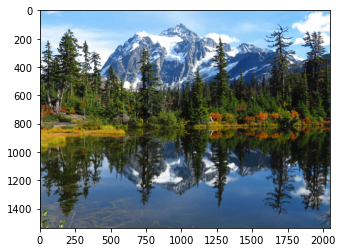

In [11]:
plt.imshow(img_RGB)

In [12]:
distortion_k=[0.01,0.01,0.02]
img_distorted= radial_distortion(img,distortion_k)
img_distorted = cv.cvtColor(img_distorted, cv.COLOR_RGB2BGR)


In [13]:
#img_distorted = cv.resize(img_distorted, dsize=(200, 300), interpolation=cv.INTER_CUBIC)

In [14]:
im = Image.fromarray(img_distorted)
im.save("LR/img_distorted.png")

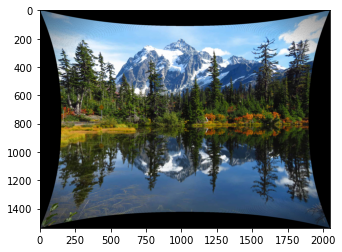

In [15]:
plt.imshow(img_distorted)

In [16]:
def tangential_distortion(img,distortion_p):
    x_dim = img.shape[0]
    y_dim = img.shape[1]
    img_distorted = np.zeros(img.shape).astype(np.uint8)
    print(x_dim,y_dim)

    ## assumed the center to be the optical center, can be changed later
    x_optic= x_dim//2
    y_optic= y_dim//2
    x_focal=x_dim//2
    y_focal= y_dim//2
    p1,p2= distortion_p
    r_max = np.sqrt(2) ## since x_norm <=1 and y_norm <=1
    x_scale = 1+ (2*p1+p2*(r_max**2+2))
    y_scale = 1+ (p1*(r_max**2+2)+2*p2)
    for x in range (x_dim):
        for y in range (y_dim):
        #Normalized image coordinates are calculated from pixel coordinates by translating to the optical center and dividing by the focal length in pixels.
            x_norm = (x-x_optic)/x_focal
            y_norm = (y-y_optic)/y_focal
        # r= x**2 + y**2 
            r = np.sqrt(x_norm**2 + y_norm**2)
            x_dist_norm = (x_norm+(2*p1*x_norm*y_norm+p2*(r**2+2*x_norm**2)))/x_scale
            y_dist_norm = (y_norm+(p1*(r**2+2*y_norm**2)+2*p2*x_norm*y_norm))/y_scale
            x_distorted = int(x_dist_norm*x_focal + x_optic) 
            y_distorted = int(y_dist_norm*y_focal + y_optic) 
            try:
               # print(x_distorted,y_distorted,x,y)
                img_distorted[x_distorted][y_distorted]=img[x][y]
            except:
                print("dimension unmatched",x_distorted,y_distorted)
                pass
                
    return img_distorted 

In [17]:
img_RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
distortion_p=[0.02,0.05]

In [18]:
img_tang_distorted= tangential_distortion(img,distortion_p)
img_tang_distorted = cv.cvtColor(img_tang_distorted, cv.COLOR_RGB2BGR)


1536 2048


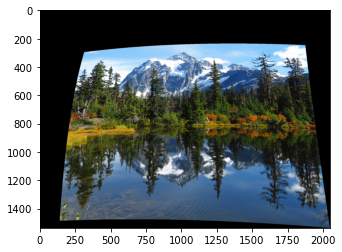

In [19]:
plt.imshow(img_tang_distorted)

In [20]:
im = Image.fromarray(img_tang_distorted)
im.save("LR/img_tang_distorted.png")

In [21]:
distort_limit=2.5
shift_limit=0.9
interpolation=1
border_mode=4
value=None
mask_value=None

In [22]:
optic_distort=A.augmentations.geometric.transforms.OpticalDistortion(distort_limit,shift_limit,interpolation=1,border_mode=4,value=None,mask_value=None,always_apply=False,p=1)


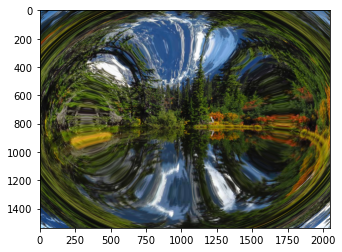

In [23]:
augmented_image = optic_distort(image=img)['image']
augmented_image = cv.cvtColor(augmented_image, cv.COLOR_BGR2RGB)

plt.imshow(augmented_image)

In [24]:
# class albumentations.augmentations.geometric.transforms.OpticalDistortion (distort_limit=0.05, shift_limit=0.05, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5) [view source on GitHub] ¶
# Parameters:

# Name	Type	Description
# distort_limit	float, [float, float]	
# If distort_limit is a single float, the range will be (-distort_limit, distort_limit). Default: (-0.05, 0.05).

# shift_limit	float, [float, float]	
# If shift_limit is a single float, the range will be (-shift_limit, shift_limit). Default: (-0.05, 0.05).

# interpolation	OpenCV flag	
# flag that is used to specify the interpolation algorithm. Should be one of: cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4. Default: cv2.INTER_LINEAR.

# border_mode	OpenCV flag	
# flag that is used to specify the pixel extrapolation method. Should be one of: cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE, cv2.BORDER_REFLECT, cv2.BORDER_WRAP, cv2.BORDER_REFLECT_101. Default: cv2.BORDER_REFLECT_101

# value	int, float, list of ints, list of float	
# padding value if border_mode is cv2.BORDER_CONSTANT.

# mask_value	int, float, list of ints, list of float	
# padding value if border_mode is cv2.BORDER_CONSTANT applied for masks.

# Transfer learning from ESRGAN

In [25]:
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk

        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))

        return out


In [ ]:


model_path = 'models/RRDB_ESRGAN_x4.pth' 
device = torch.device('cpu')  

test_img_folder = 'LR/*'

model = arch.RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

print('Model path {:s}. \nTesting...'.format(model_path))

idx = 0
for path in glob.glob(test_img_folder):
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)
    # read images
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(device)

    with torch.no_grad():
        output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()
    cv2.imwrite('results/{:s}_rlt.png'.format(base), output)
print("Transformation complete")

Model path models/RRDB_ESRGAN_x4.pth. 
Testing...
1 original_image1
2 img_distorted
